# Hackathon

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import lightgbm as lgbm
from prophet import Prophet
import seaborn as sns


In [2]:
df = pd.read_csv('train/train_data.csv')
df["MEASURED_IN_DATE"] = pd.to_datetime(df["MEASURED_IN_DATE"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177575 entries, 0 to 177574
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   MEASURED_IN_DATE   177575 non-null  datetime64[ns]
 1   WELL_NAME          177575 non-null  object        
 2   KCHARWORK          177575 non-null  float64       
 3   CHARWORK           177575 non-null  object        
 4   MEASURED_IN        177575 non-null  object        
 5   LIQ_RATE           177575 non-null  float64       
 6   WATER_CUT          177575 non-null  float64       
 7   P_ZAB              166194 non-null  float64       
 8   INTAKE             177575 non-null  float64       
 9   WELLHEAD_PRESSURE  50393 non-null   float64       
 10  IS_WORKING         177575 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(6), object(3)
memory usage: 13.7+ MB


In [3]:
# rename cols for prophet
df.rename(columns={"MEASURED_IN_DATE": "ds", "LIQ_RATE": "y"}, inplace=True)

In [4]:
def stan_init(m):
    """Retrieve parameters from a trained model.

    Retrieve parameters from a trained model in the format
    used to initialize a new Stan model.

    Parameters
    ----------
    m: A trained model of the Prophet class.

    Returns
    -------
    A Dictionary containing retrieved parameters of m.

    """
    res = {}
    for pname in ['k', 'm', 'sigma_obs']:
        res[pname] = m.params[pname][0]
    for pname in ['delta', 'beta']:
        res[pname] = m.params[pname][0][0]
    return res


In [5]:
# final dataframe for big image 
test = pd.DataFrame()

# big image settings
figure = plt.gcf()
figure.set_size_inches(30, 2)

m1 = Prophet()
# fit every well separately
for i in range(len(df['WELL_NAME'].unique())):
    dff = pd.DataFrame(df.loc[df['WELL_NAME']==df['WELL_NAME'].unique()[i]])
    m2 = Prophet()

    test_data_size = int(len(dff)*0.2)
    if i>0:
        m2.fit(df[:test_data_size], init = stan_init(m1)) # todo fix crash???
    else:
        m2.fit(df[:test_data_size])
    future = m2.make_future_dataframe(periods=test_data_size) #forecasting 365 days in future
    forecast = m2.predict(future)

    m1 = m2

    test = pd.DataFrame(pd.concat([test,forecast], ignore_index=True))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\Users\andre\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\andre\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\andre\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling yearly seasonality. Run prophet with 

KeyboardInterrupt: 

<Figure size 3000x200 with 0 Axes>

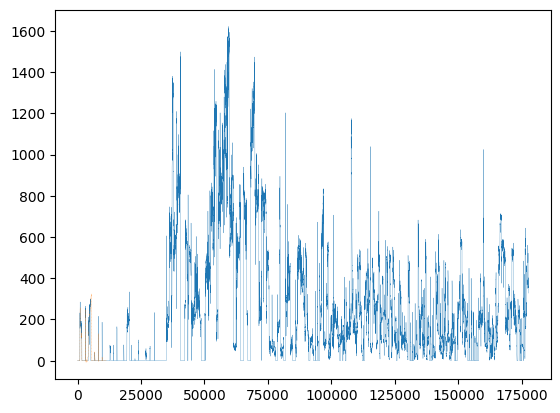

In [5]:
plt.plot(df['y'], linewidth = 0.2)
plt.plot(test['trend'], linewidth = 0.2, linestyle = '--')
plt.savefig("myplot.png", dpi = 1000)

Next i try to fit prophet with all data and then forecast something, which didn't work

In [589]:
train_stop_name = df['WELL_NAME'][len(df)-int(len(df)*0.2)]
train_stop_index = df.index[df['WELL_NAME'] == train_stop_name][0]
train_stop_index

142043

In [590]:
test_data_size = len(df)-train_stop_index
test_data_size

35532

In [591]:
m = Prophet()
m.fit(df[:-test_data_size])

03:24:53 - cmdstanpy - INFO - Chain [1] start processing
03:25:37 - cmdstanpy - INFO - Chain [1] done processing


In [592]:
future = m.make_future_dataframe(periods = 120)
forecast = m.predict(future)

In [593]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-08-02,792.557860,387.891405,1187.376387,792.557860,792.557860,3.075333,3.075333,3.075333,0.032965,0.032965,0.032965,3.042367,3.042367,3.042367,0.0,0.0,0.0,795.633193
1,2016-08-03,791.825890,454.029612,1203.599216,791.825890,791.825890,2.650165,2.650165,2.650165,-0.587197,-0.587197,-0.587197,3.237361,3.237361,3.237361,0.0,0.0,0.0,794.476054
2,2016-08-04,791.093920,426.430481,1173.967140,791.093920,791.093920,3.304992,3.304992,3.304992,-0.161380,-0.161380,-0.161380,3.466372,3.466372,3.466372,0.0,0.0,0.0,794.398911
3,2016-08-05,790.361949,407.226604,1165.261764,790.361949,790.361949,3.957973,3.957973,3.957973,0.227851,0.227851,0.227851,3.730122,3.730122,3.730122,0.0,0.0,0.0,794.319923
4,2016-08-06,789.629979,389.683564,1182.213015,789.629979,789.629979,4.457112,4.457112,4.457112,0.428438,0.428438,0.428438,4.028673,4.028673,4.028673,0.0,0.0,0.0,794.087091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2237,2022-09-24,244.207600,-134.105299,614.524210,230.733919,257.785927,8.507882,8.507882,8.507882,0.428438,0.428438,0.428438,8.079443,8.079443,8.079443,0.0,0.0,0.0,252.715482
2238,2022-09-25,244.398728,-122.681258,639.849091,230.781096,258.362973,8.091405,8.091405,8.091405,-0.350122,-0.350122,-0.350122,8.441527,8.441527,8.441527,0.0,0.0,0.0,252.490132
2239,2022-09-26,244.589855,-123.997254,633.496045,230.828273,258.763917,9.240713,9.240713,9.240713,0.409444,0.409444,0.409444,8.831269,8.831269,8.831269,0.0,0.0,0.0,253.830568
2240,2022-09-27,244.780982,-128.502368,630.033948,230.875451,259.123382,9.274163,9.274163,9.274163,0.032965,0.032965,0.032965,9.241198,9.241198,9.241198,0.0,0.0,0.0,254.055145


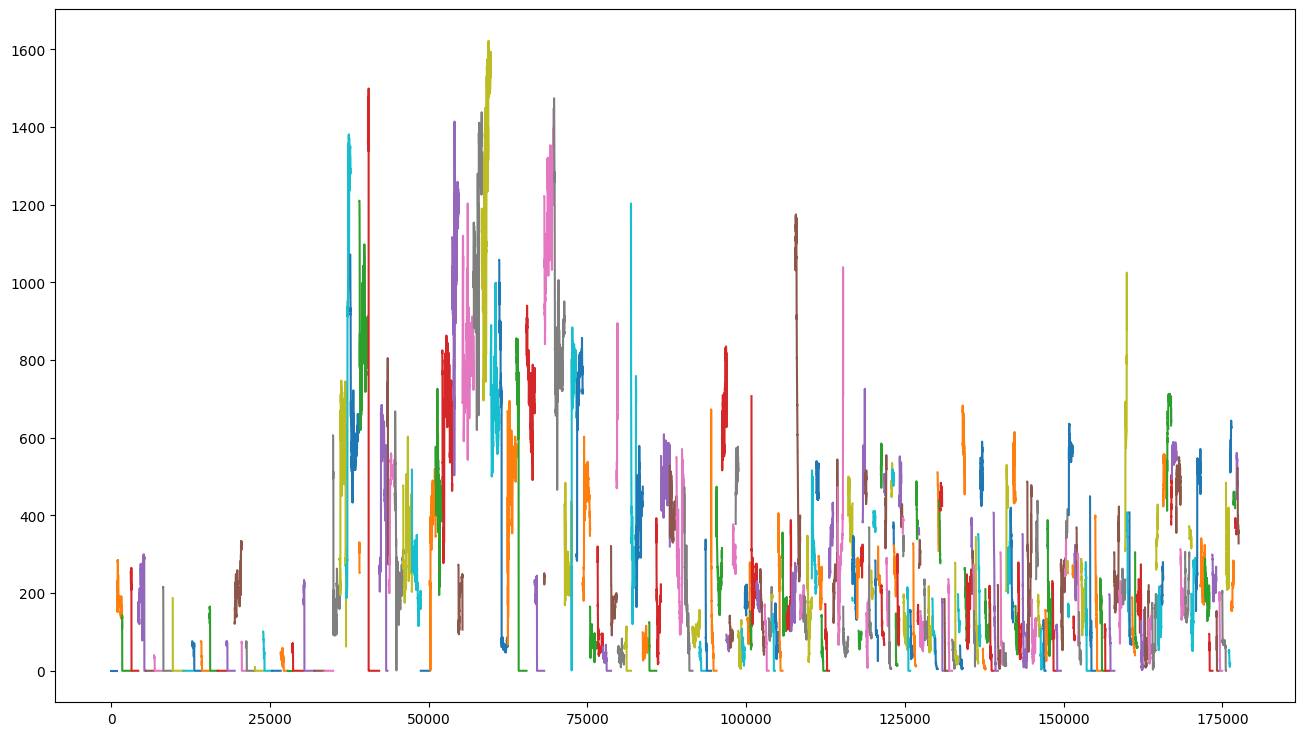

In [616]:
#plt.plot(forecast["ds"].values, forecast["trend"].values)
n=2000
figure = plt.gcf()
figure.set_size_inches(16, 9)
grouped = df.groupby("WELL_NAME")
for name in df.WELL_NAME.unique():
    plt.plot(grouped.get_group(name)["y"])
#np.datetime64(df["ds"].values[0])
#plt.show()